In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel

# Set random seed for reproducibility

In [32]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

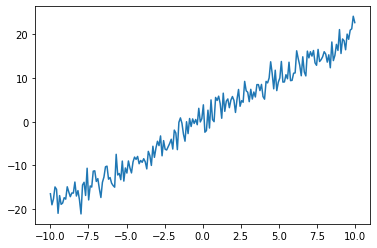

In [33]:
# generate linear time series data with some noise
n = 200
x_max = 10
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(-x_max, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

### Make test set

In [34]:
# Make test set
x_test = x
y_test = 2 * x

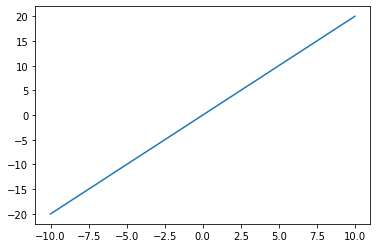

In [35]:
plt.plot(x, y_test)
plt.show()

In [36]:
# split to three sections
window_size = n//3
if n % 3 == 0:
    # If an even split of data, then give each dataset n//3 entries
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 1:
    # if there's 1 left, it automatically gets added to the test set
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 2:
    # if there's 2 extra data points, add one to calibration, then other extra will go towards test
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2+1]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2+1]
    y_test = y[window_size*2:]

# Define model that predicts quantiles

In [37]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [38]:
input_size = 1
output_size = 1
hidden_size = 16
quantile = 0.5
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [39]:
n

200

In [40]:
# Split our training dataset into training and calibration sets randomly
# and correct to maintain the timeseries convention of ascending x
idx = np.random.permutation(n)
n_half = int(np.floor(n/2))
idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])

In [41]:
# Perform split using our split indices
x_train = x.numpy()[idx_train]
x_cal = x.numpy()[idx_cal]

y_train = y.numpy()[idx_train]
y_cal = y.numpy()[idx_cal]

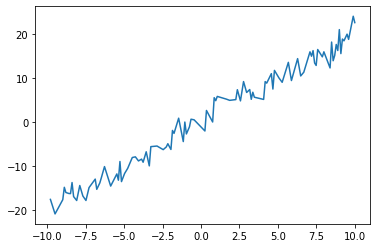

In [11]:
plt.plot(torch.tensor(x_train), torch.tensor(y_train))
plt.show()

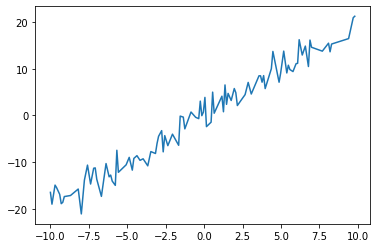

In [12]:
plt.plot(torch.tensor(x_cal), torch.tensor(y_cal))
plt.show()

# Train model to predict multiple quantiles

In [15]:
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [16]:
# train model
model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# inference
y_preds = model.predict(x)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the valu

Epoch 99: 100%|█| 20/20 [00:00<00:00, 166.14it/s, loss=1.02, v_num=3, train_loss


In [ ]:
# n_quantiles = len(quantile)
# cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_index = [2, 1, 3]

# plt.plot(x, y, label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()
# plt.show()

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_cal_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

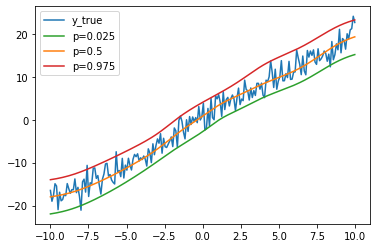

In [17]:
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

### Begin implementation of conformal prediction code

In [18]:
def quantile_err(prediction, y):
    """
    prediction: arr where first 3 columns are: lower quantile, middle quantile (50%), upper quantile in that order
    """
    y_lower = prediction[:, 0]
    y_upper = prediction[:, 2]
    # Calculate error on our predicted upper and lower quantiles
    # this will get us an array of negative values with the distance between the upper/lower quantile and the
    # 50% quantile
    error_low = y_lower - y
    error_high = y - y_upper
    # Make an array where each entry is the highest error when comparing the upper and lower bounds for that entry prediction 
    err = np.maximum(error_high, error_low)
    return err

In [19]:
# Find quantile error of our model
quantile_err(y_preds, y_preds[:, 1])

tensor([-3.9836, -3.9785, -3.9730, -3.9672, -3.9611, -3.9545, -3.9476, -3.9402,
        -3.9324, -3.9242, -3.9155, -3.9063, -3.8966, -3.8865, -3.8759, -3.8647,
        -3.8531, -3.8410, -3.8284, -3.8152, -3.8016, -3.7875, -3.7730, -3.7580,
        -3.7425, -3.7266, -3.7104, -3.6937, -3.6767, -3.6593, -3.6415, -3.6235,
        -3.6051, -3.5864, -3.5674, -3.5482, -3.5286, -3.5088, -3.4887, -3.4683,
        -3.4476, -3.4267, -3.4055, -3.3840, -3.3623, -3.3403, -3.3181, -3.2956,
        -3.2730, -3.2501, -3.2271, -3.2040, -3.1808, -3.1577, -3.1346, -3.1116,
        -3.0889, -3.0666, -3.0448, -3.0236, -3.0032, -2.9839, -2.9659, -2.9494,
        -2.9348, -2.9223, -2.9124, -2.9055, -2.9019, -2.9020, -2.9063, -2.9150,
        -2.9285, -2.9469, -2.9702, -2.9981, -3.0304, -3.0664, -3.1054, -3.1466,
        -3.1891, -3.2320, -3.2744, -3.3156, -3.3549, -3.3918, -3.4261, -3.4575,
        -3.4820, -3.4734, -3.4629, -3.4505, -3.4359, -3.4188, -3.3991, -3.3763,
        -3.3504, -3.3208, -3.2874, -3.24

In [20]:
# store our quantile errors into variable named for calibration scores
cal_scores = quantile_err(y_preds, y_preds[:, 1])

In [21]:
# Make a dictionary where our calibration scores (errors) are sorted in descending order
nc = {0: np.sort(cal_scores, 0)[::-1]}

In [22]:
# Specify significance we would like to see for our coverage when dealing with conformal prediction
significance = .9

In [23]:
# Sort calibration scores in ascending order? TODO make sure this is correct
# this is the apply_inverse portion of RegressorNC predict function
nc = np.sort(cal_scores,0)

index = int(np.ceil((1-significance) * (nc.shape[0] + 1))) - 1
# find largest error that gets us guaranteed coverage
index = min(max(index, 0), nc.shape[0] - 1)

err_dist = np.vstack([nc[index], nc[index]])

In [24]:
err_dist

array([[-3.939785],
       [-3.939785]], dtype=float32)

In [25]:
# store the predictions from our nonconformal quantile regressor
prediction = y_preds

In [26]:
intervals = np.zeros((x.shape[0],2))
# TODO ensure that we want to multiply our error distances by the size of our training set
err_dist = np.hstack([err_dist] * n)

In [27]:
# CQR

# grab the first and last intervals predicted from our nonconformal quantile regressor in order to
# calculate our new intervals that fit our coverage requirements
intervals[:, 0] = prediction[:,0] - err_dist[0, :]
intervals[:, 1] = prediction[:, -1] + err_dist[1,:]

conformal_intervals = intervals

IndexError: index 2 is out of bounds for axis 1 with size 2

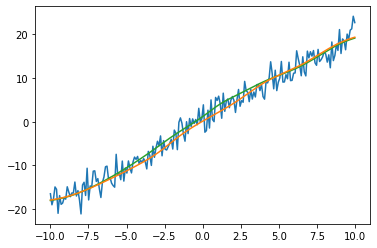

In [28]:
# n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(len(conformal_intervals)), color_index):
    plt.plot(x, conformal_intervals[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# End of conformal implementation

# Add second response variable

In [29]:
# y_max = slope * x_max
# y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
# y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
# y = torch.hstack([y, y2])

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0])
# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1])
# plt.show()

# Train model to predict quantiles for two response variables

In [ ]:
# output_size = 2

# model = QuantileLSTM(
#     input_size,
#     output_size,
#     hidden_size,
#     optimizer,
#     quantile=quantile,
#     optimizer_args=optimizer_args,
# )

In [ ]:
# # train model
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# # inference
# y_preds = model.predict(x)

In [ ]:
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.show()